In [65]:
# Using colab, catboost model has to installed
!pip install catboost

In [66]:
# IMporting all required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble._hist_gradient_boosting.gradient_boosting import train_test_split
import numpy as np
from scipy.stats import skew, kurtosis
import scipy.stats as stats
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score

# READING IN THE DATA

In [3]:
train = pd.read_csv('Housing_dataset_train.csv')
test = pd.read_csv('Housing_dataset_test.csv')

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             14000 non-null  int64  
 1   loc            12187 non-null  object 
 2   title          12278 non-null  object 
 3   bedroom        12201 non-null  float64
 4   bathroom       12195 non-null  float64
 5   parking_space  12189 non-null  float64
 6   price          14000 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 765.8+ KB


In [ ]:
train.isna().sum()

ID                  0
loc              1813
title            1722
bedroom          1799
bathroom         1805
parking_space    1811
price               0
dtype: int64

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ID             6000 non-null   int64 
 1   loc            6000 non-null   object
 2   title          6000 non-null   object
 3   bedroom        6000 non-null   int64 
 4   bathroom       6000 non-null   int64 
 5   parking_space  6000 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 281.4+ KB


# PREPROCESSING

In [86]:
dropped = train.dropna() # Drop the null values

In [87]:
#Loop through each column and print out the unique values
for col in dropped.columns:
    print("UNIQUE VALUES FOR", col, "COLUMN")
    print(np.unique(dropped[col]))

UNIQUE VALUES FOR ID COLUMN
[    0     1     2 ... 12986 12987 12997]
UNIQUE VALUES FOR loc COLUMN
['Abia' 'Adamawa' 'Akwa Ibom' 'Anambra' 'Bauchi' 'Bayelsa' 'Benue' 'Borno'
 'Cross River' 'Delta' 'Ebonyi' 'Edo' 'Ekiti' 'Enugu' 'Gombe' 'Imo'
 'Jigawa' 'Kaduna' 'Kano' 'Katsina' 'Kebbi' 'Kogi' 'Kwara' 'Lagos'
 'Nasarawa' 'Niger' 'Ogun' 'Ondo' 'Osun' 'Oyo' 'Plateau' 'Rivers' 'Sokoto'
 'Taraba' 'Yobe' 'Zamfara']
UNIQUE VALUES FOR title COLUMN
['Apartment' 'Bungalow' 'Cottage' 'Detached duplex' 'Flat' 'Mansion'
 'Penthouse' 'Semi-detached duplex' 'Terrace duplex' 'Townhouse']
UNIQUE VALUES FOR bedroom COLUMN
[1. 2. 3. 4. 5. 6. 7. 8. 9.]
UNIQUE VALUES FOR bathroom COLUMN
[1. 2. 3. 4. 5. 6. 7.]
UNIQUE VALUES FOR parking_space COLUMN
[1. 2. 3. 4. 5. 6.]
UNIQUE VALUES FOR price COLUMN
[  431967.29     455591.2271   552016.8649 ... 10190071.99   12459581.99
 13449422.32  ]


## Filling the data

In [68]:
mode_filled = train.copy() # Copy the train dataset to fill with mode

In [82]:
# Loop through each column, get the mode using stats and then fill null values with mode
for col in train.columns:
  if col != "price":
    mode = stats.mode(train[col].dropna()).mode[0]
    print(mode)
    mode_filled[col] = train[col].fillna(mode)

0
Kaduna
Flat
5.0
1.0
4.0


<ipython-input-82-5db8ee7a7527>:4: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(train[col].dropna()).mode[0]
<ipython-input-82-5db8ee7a7527>:4: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html.
  mode = stats.mode(train[col].dropna()).mode[0]


## Encoding data

In [70]:
obj_cols = train.select_dtypes(include = "object").columns # select all the columns that are not numeric

In [85]:
# Copy the test data twice, one for the dropped null values and the other for the filled null null values
test_cpy_dropped = test.copy()
test_cpy_mode_filled = test.copy()

In [88]:
# loop through each of the non numeric columns, initialize the label encoder to fit and transform the train data, then use to convert the test_data
for c in obj_cols:
  le = LabelEncoder()
  dropped[c] = le.fit_transform(dropped[c])
  test_cpy_dropped.loc[:,c] = le.transform(test_cpy_dropped[c])

<ipython-input-88-400d46cb175b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dropped[c] = le.fit_transform(dropped[c])
<ipython-input-88-400d46cb175b>:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_cpy_dropped.loc[:,c] = le.transform(test_cpy_dropped[c])
<ipython-input-88-400d46cb175b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

In [89]:
# loop through each of the non numeric columns, initialize the label encoder to fit and transform the train data, then use to convert the test_data for the mode filled
for c in obj_cols:
    le = LabelEncoder()
    mode_filled[c] = le.fit_transform(mode_filled[c])
    test_cpy_mode_filled[c] = le.transform(test_cpy_mode_filled[c])

In [90]:
dropped.isna().sum()

ID               0
loc              0
title            0
bedroom          0
bathroom         0
parking_space    0
price            0
dtype: int64

In [91]:
mode_filled.isna().sum()

ID               0
loc              0
title            0
bedroom          0
bathroom         0
parking_space    0
price            0
dtype: int64

# EDA

## NUMERICAL

In [92]:
id_dropped = dropped.drop(["ID"], axis = 1)

In [93]:
id_dropped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5689 entries, 0 to 13997
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   loc            5689 non-null   int64  
 1   title          5689 non-null   int64  
 2   bedroom        5689 non-null   float64
 3   bathroom       5689 non-null   float64
 4   parking_space  5689 non-null   float64
 5   price          5689 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 311.1 KB


### Nature of distribution

#### Skweness check and Kutosis check

* Skewness: Skewness measures the symmetry of the data distribution. A skewness value of 0 indicates perfect symmetry. Positive skewness (skewness > 0) indicates a longer tail on the right side of the distribution, while negative skewness (skewness < 0) indicates a longer tail on the left side. Generally, if the skewness value is within the range of -1 to +1, the data is considered approximately symmetric.
* Kurtosis: Kurtosis measures the heaviness of the tails of the distribution. A kurtosis value of 3 indicates that the tails of the distribution are similar to the tails of a normal distribution. Higher kurtosis (kurtosis > 3) indicates heavier tails, while lower kurtosis (kurtosis < 3) indicates lighter tails. Extreme values of kurtosis may suggest the presence of outliers.

In [96]:

# Skewness for each col
for col in id_dropped.columns:
  if col not in obj_cols:
    data_skewness = skew(id_dropped[col])
    print(f"Skewness for {col} column:", data_skewness)

    # Kurtosis
    data_kurtosis = kurtosis(id_dropped[col])
    print(f"Kurtosis for {col} column:", data_kurtosis)

Skewness for bedroom column: 0.4078291675148457
Kurtosis for bedroom column: -0.8847521159086233
Skewness for bathroom column: 0.6184285155195125
Kurtosis for bathroom column: -1.003424204684963
Skewness for parking_space column: 0.2566405188707025
Kurtosis for parking_space column: -1.0353470791330168
Skewness for price column: 1.9797999657867729
Kurtosis for price column: 7.958219335790787


#### Visual distribution check

Q-Q plots are used to visually assess whether a dataset follows a normal distribution. In the plot, the data points are plotted against the theoretical quantiles of the normal distribution. If the data points follow a straight line, it suggests that the data is normally distributed. If the points deviate from the straight line, it indicates a departure from normality. The closer the points are to the straight line, the closer the data is to a normal distribution.

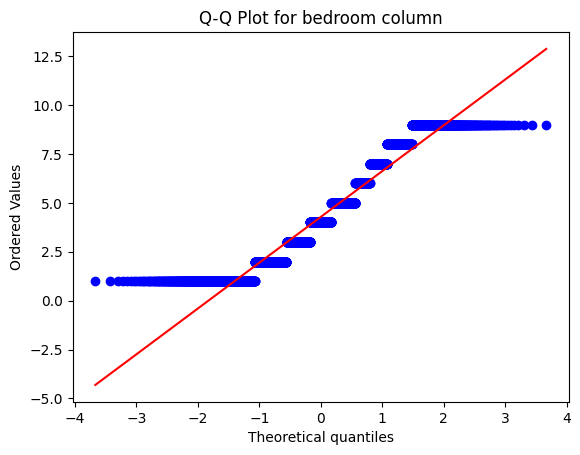

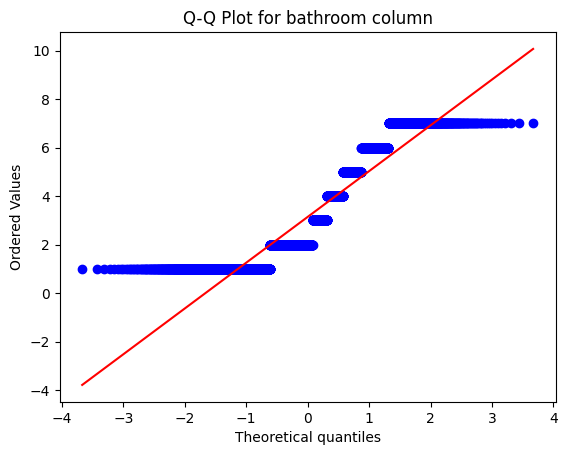

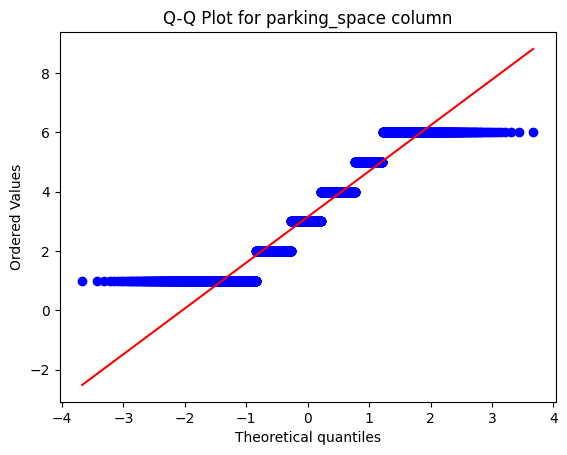

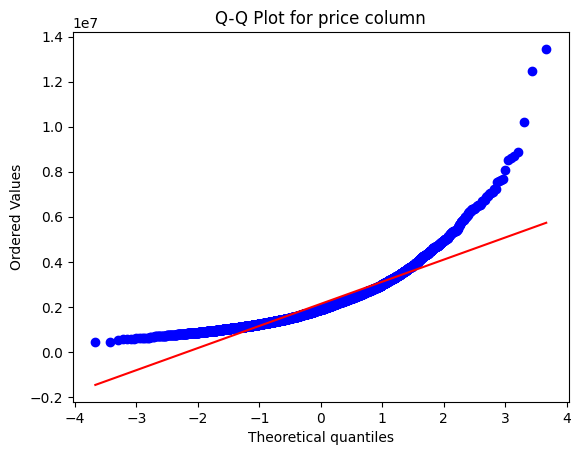

In [97]:
# Q-Q plot
for col in id_dropped.columns:
  if col not in obj_cols:
    stats.probplot(id_dropped[col].values, dist="norm", plot=plt)

    plt.title(f"Q-Q Plot for {col} column")
    plt.show()


DIST PLOTS

<ipython-input-98-7c5c965d3599>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(id_dropped[col])


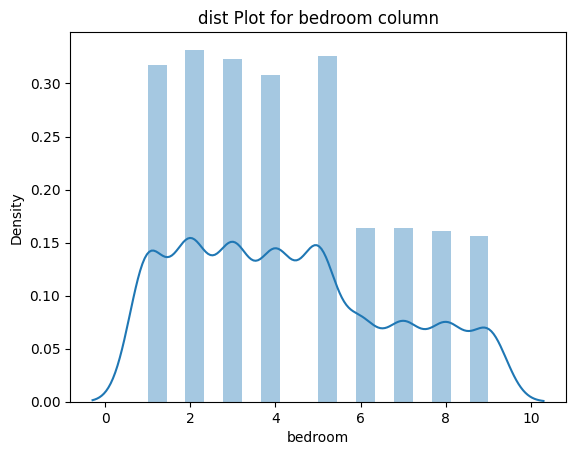

<ipython-input-98-7c5c965d3599>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(id_dropped[col])


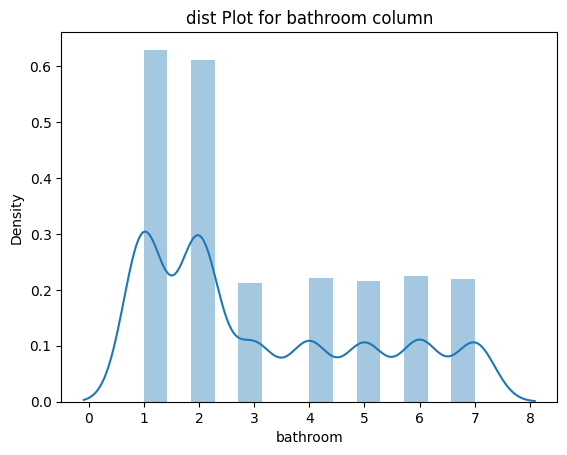

<ipython-input-98-7c5c965d3599>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(id_dropped[col])


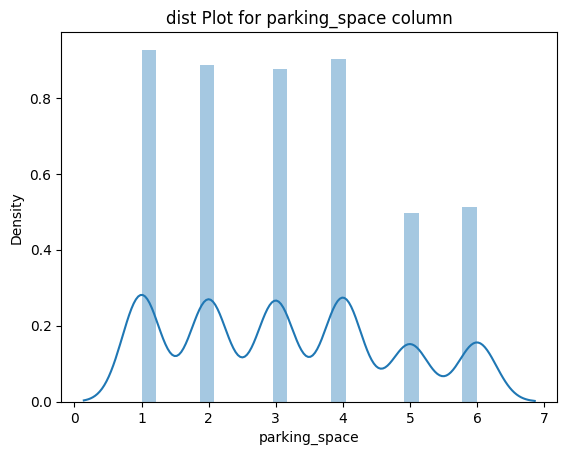

<ipython-input-98-7c5c965d3599>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(id_dropped[col])


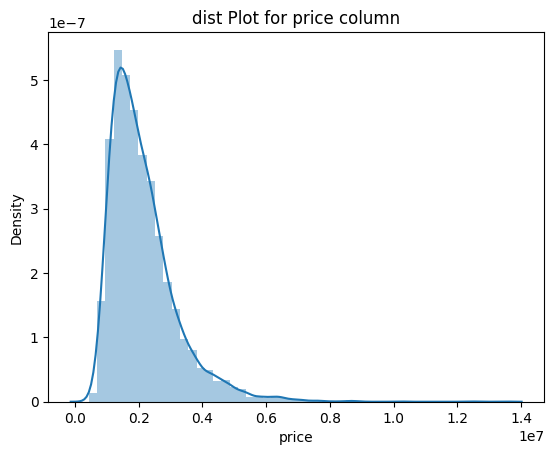

In [98]:
for col in id_dropped.columns:
  if col not in obj_cols:
    sns.distplot(id_dropped[col])

    plt.title(f"dist Plot for {col} column")
    plt.show()

### CORRELATION

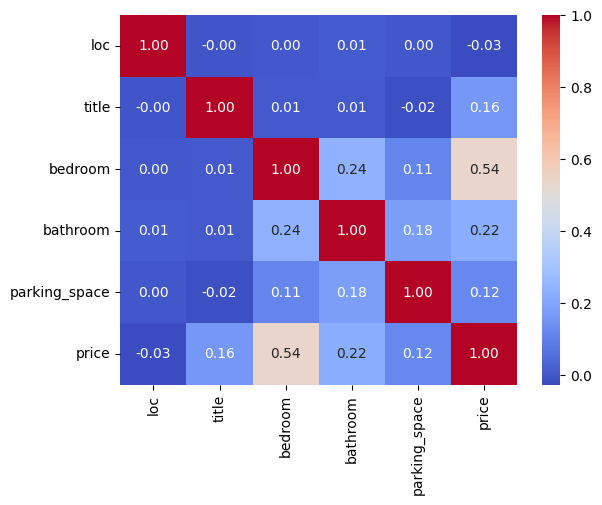

In [102]:
sns.heatmap(id_dropped.corr(), cbar = True, fmt='.2f', annot = True, cmap='coolwarm')
plt.savefig('corr.jpg', bbox_inches = 'tight')

### Outlier

<AxesSubplot:xlabel='price'>

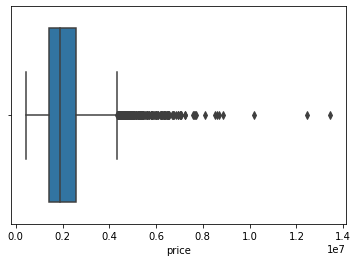

In [ ]:
sns.boxplot(x = "price", data = id_dropped)

## Categorical

In [127]:
cat_df = train.dropna().drop(['ID'], axis = 1)

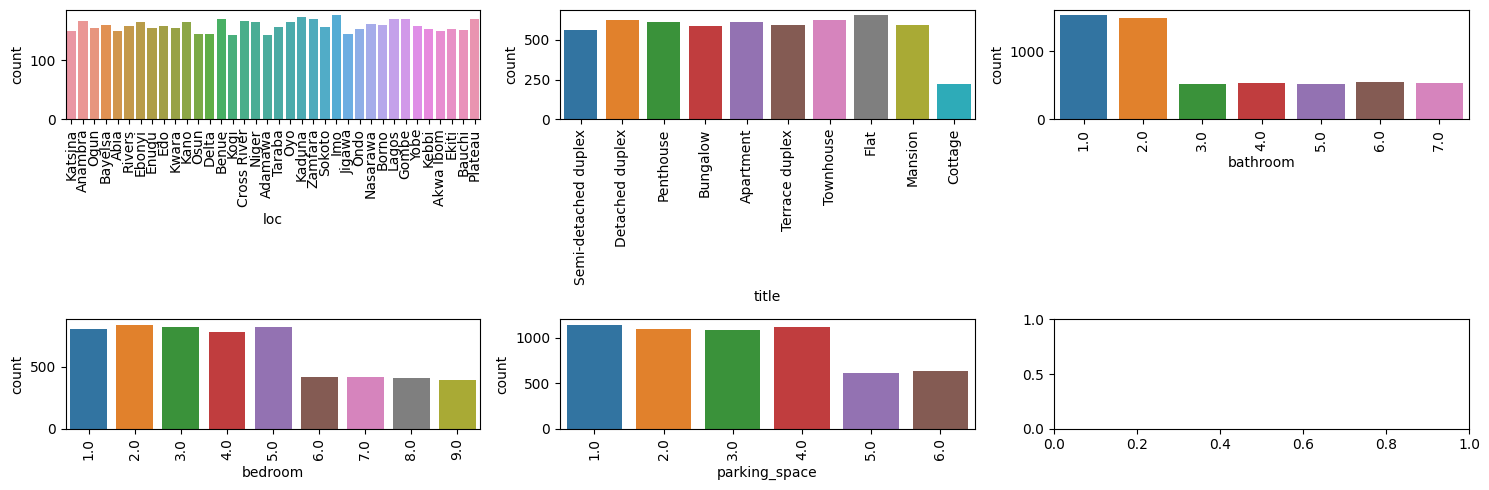

In [140]:
fig, axes = plt.subplots(2, 3, figsize = (15,5)) # Create a subplot of 2 rows and 3 columns
cols_to_show = [["loc", "title", "bathroom"], ["bedroom","parking_space"]] # This is structured the way the axes list is structured
for i, ax in enumerate(axes): #Loop through the axes and crteate a countplot for each columns in the list
  for j, ax_s in enumerate(ax):
    if i == 1 and j == 2:
      continue
    sns.countplot(x = cols_to_show[i][j], data = cat_df, ax = ax_s)
    ax_s.tick_params(axis='x', labelrotation = 90)
fig.tight_layout()
plt.savefig('cnts.jpg')
plt.show()

## Multi-variate analysis

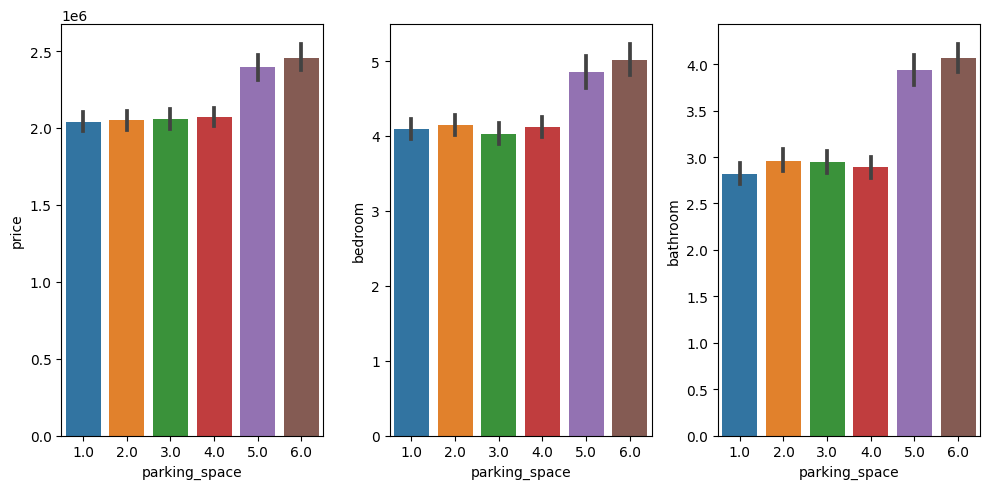

In [119]:
p_l = ["price", "bedroom", "bathroom"]
fig, axes = plt.subplots(1, 3, figsize = (10,5))
for i, ax in enumerate(axes):
  sns.barplot(x = 'parking_space', y = p_l[i], data = dropped, ax = ax)
fig.tight_layout()
plt.savefig("pspace-price.jpg")

In [141]:
house_type_grouping = cat_df.groupby('title') #group the dataset by the title colum

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Apartment'),
  Text(1, 0, 'Bungalow'),
  Text(2, 0, 'Cottage'),
  Text(3, 0, 'Detached duplex'),
  Text(4, 0, 'Flat'),
  Text(5, 0, 'Mansion'),
  Text(6, 0, 'Penthouse'),
  Text(7, 0, 'Semi-detached duplex'),
  Text(8, 0, 'Terrace duplex'),
  Text(9, 0, 'Townhouse')])

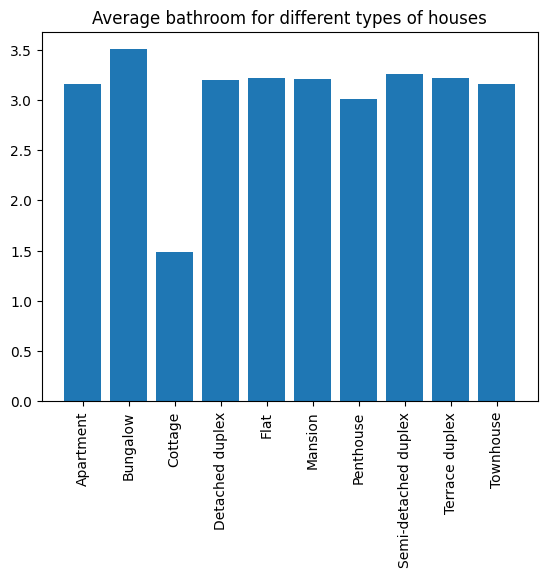

In [142]:
avg_bathrooms_per_houstype = []
for grp in house_type_grouping.groups.keys(): # get all of the different type of houses
    curr_grp_df = house_type_grouping.get_group(grp) # get a subset of the dataset which correspond to the type of house selected
    avg_bathrooms_per_houstype.append(np.average(curr_grp_df['bathroom'])) # Then calculate the average

plt.bar(np.unique(cat_df['title']), avg_bathrooms_per_houstype)
plt.title('Average bathroom for different types of houses')
plt.xticks(rotation = 90)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Apartment'),
  Text(1, 0, 'Bungalow'),
  Text(2, 0, 'Cottage'),
  Text(3, 0, 'Detached duplex'),
  Text(4, 0, 'Flat'),
  Text(5, 0, 'Mansion'),
  Text(6, 0, 'Penthouse'),
  Text(7, 0, 'Semi-detached duplex'),
  Text(8, 0, 'Terrace duplex'),
  Text(9, 0, 'Townhouse')])

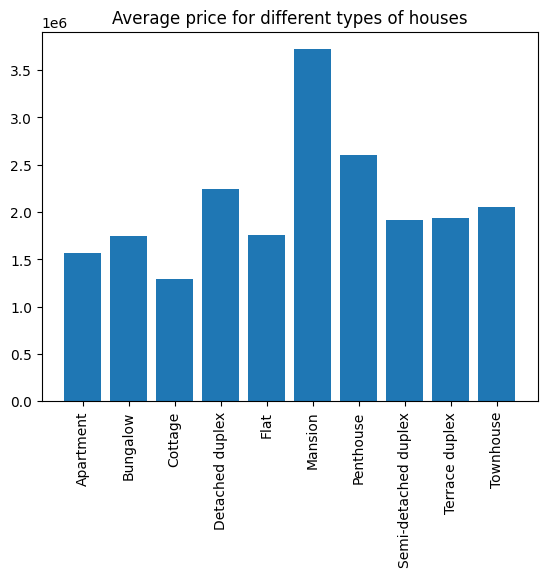

In [143]:
avg_price_per_houstype = []
for grp in house_type_grouping.groups.keys():
    curr_grp_df = house_type_grouping.get_group(grp)
    avg_price_per_houstype.append(np.average(curr_grp_df['price']))

plt.bar(np.unique(cat_df['title']), avg_price_per_houstype)
plt.title('Average price for different types of houses')
plt.xticks(rotation = 90)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Apartment'),
  Text(1, 0, 'Bungalow'),
  Text(2, 0, 'Cottage'),
  Text(3, 0, 'Detached duplex'),
  Text(4, 0, 'Flat'),
  Text(5, 0, 'Mansion'),
  Text(6, 0, 'Penthouse'),
  Text(7, 0, 'Semi-detached duplex'),
  Text(8, 0, 'Terrace duplex'),
  Text(9, 0, 'Townhouse')])

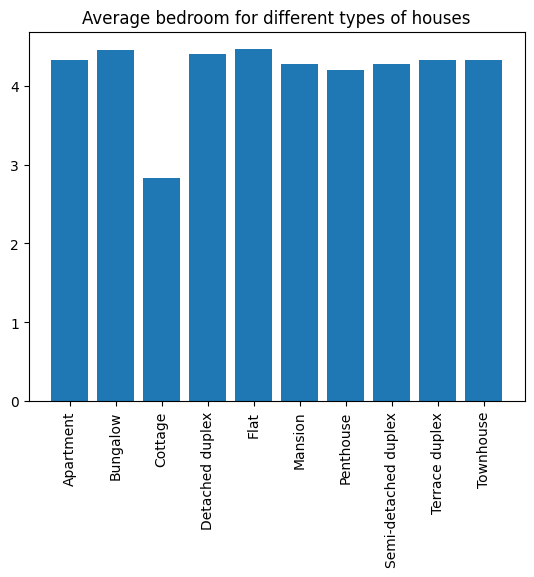

In [144]:
avg_bedrooms_per_houstype = []
for grp in house_type_grouping.groups.keys():
    curr_grp_df = house_type_grouping.get_group(grp)
    avg_bedrooms_per_houstype.append(np.average(curr_grp_df['bedroom']))

plt.bar(np.unique(cat_df['title']), avg_bedrooms_per_houstype)
plt.title('Average bedroom for different types of houses')
plt.xticks(rotation = 90)

In [145]:
state_grouping = cat_df.groupby('loc')

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35],
 [Text(0, 0, 'Abia'),
  Text(1, 0, 'Adamawa'),
  Text(2, 0, 'Akwa Ibom'),
  Text(3, 0, 'Anambra'),
  Text(4, 0, 'Bauchi'),
  Text(5, 0, 'Bayelsa'),
  Text(6, 0, 'Benue'),
  Text(7, 0, 'Borno'),
  Text(8, 0, 'Cross River'),
  Text(9, 0, 'Delta'),
  Text(10, 0, 'Ebonyi'),
  Text(11, 0, 'Edo'),
  Text(12, 0, 'Ekiti'),
  Text(13, 0, 'Enugu'),
  Text(14, 0, 'Gombe'),
  Text(15, 0, 'Imo'),
  Text(16, 0, 'Jigawa'),
  Text(17, 0, 'Kaduna'),
  Text(18, 0, 'Kano'),
  Text(19, 0, 'Katsina'),
  Text(20, 0, 'Kebbi'),
  Text(21, 0, 'Kogi'),
  Text(22, 0, 'Kwara'),
  Text(23, 0, 'Lagos'),
  Text(24, 0, 'Nasarawa'),
  Text(25, 0, 'Niger'),
  Text(26, 0, 'Ogun'),
  Text(27, 0, 'Ondo'),
  Text(28, 0, 'Osun'),
  Text(29, 0, 'Oyo'),
  Text(30, 0, 'Plateau'),
  Text(31, 0, 'Rivers'),
  Text(32, 0, 'Soko

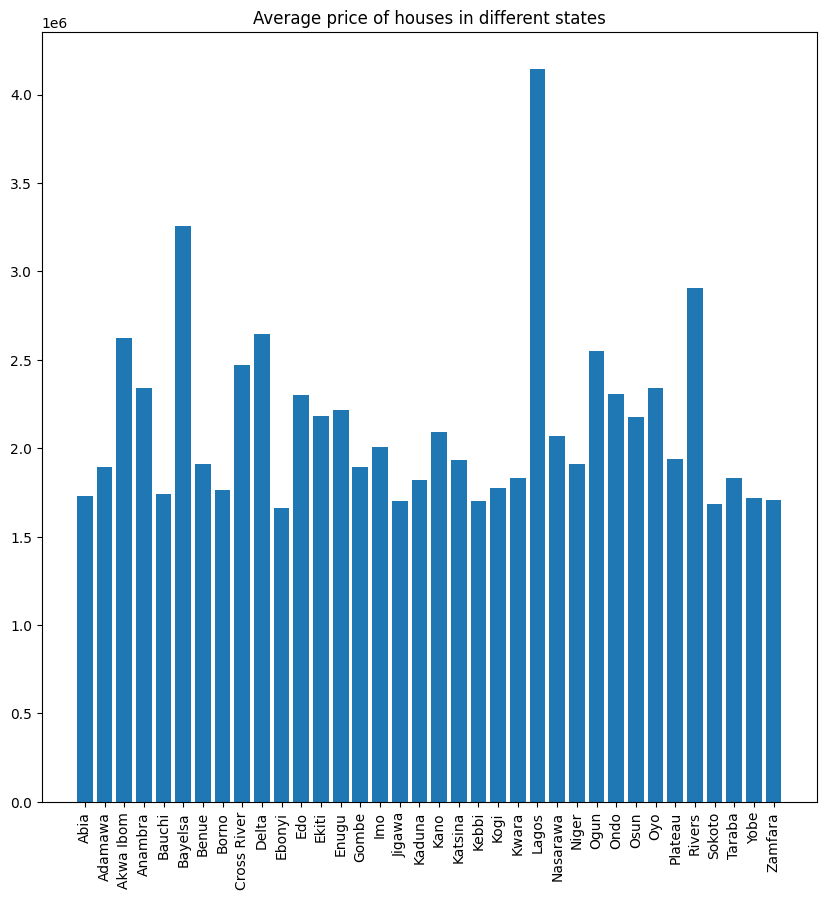

In [146]:
avg_price_per_state = []
for grp in state_grouping.groups.keys():
    curr_grp_df = state_grouping.get_group(grp)
    avg_price_per_state.append(np.average(curr_grp_df['price']))

plt.figure(figsize = (10,10))
plt.bar(np.unique(cat_df['loc']), avg_price_per_state)
plt.title('Average price of houses in different states')
plt.xticks(rotation = 90)

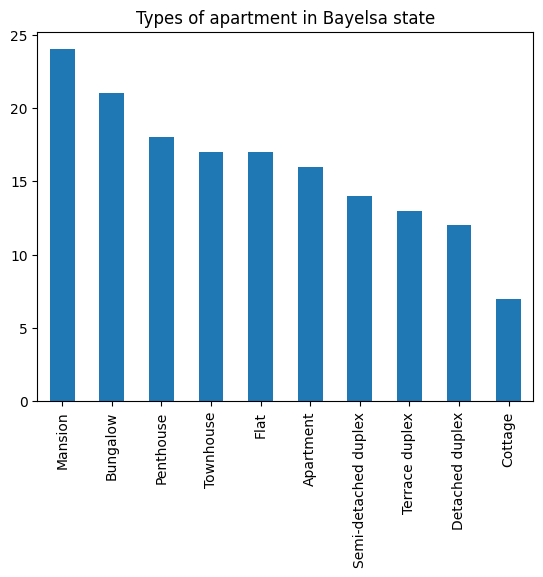

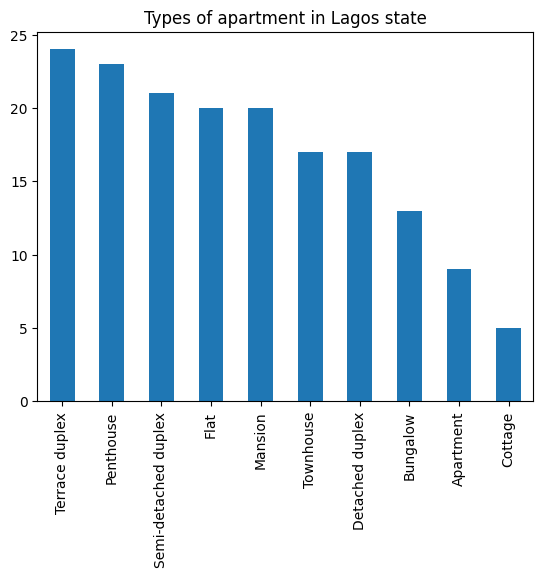

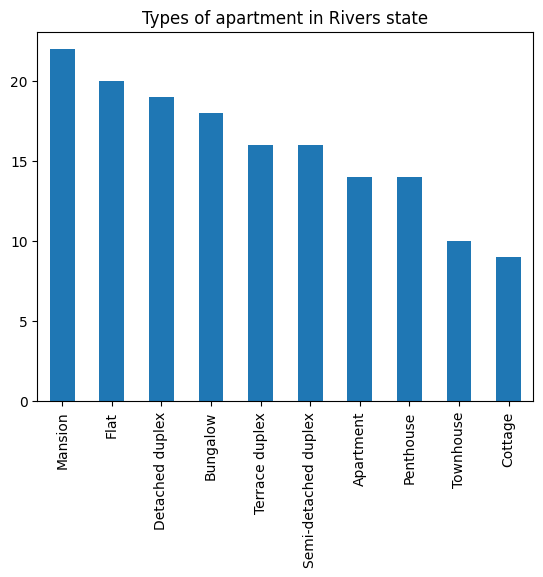

In [147]:
for grp in state_grouping.groups.keys():
    if grp in ["Lagos", "Bayelsa", "Rivers"]:
        curr_grp_df = state_grouping.get_group(grp)
        curr_grp_df.title.value_counts().plot(kind = 'bar')
        plt.title(f"Types of apartment in {grp} state")
        plt.xticks(rotation = 90)
        plt.show()

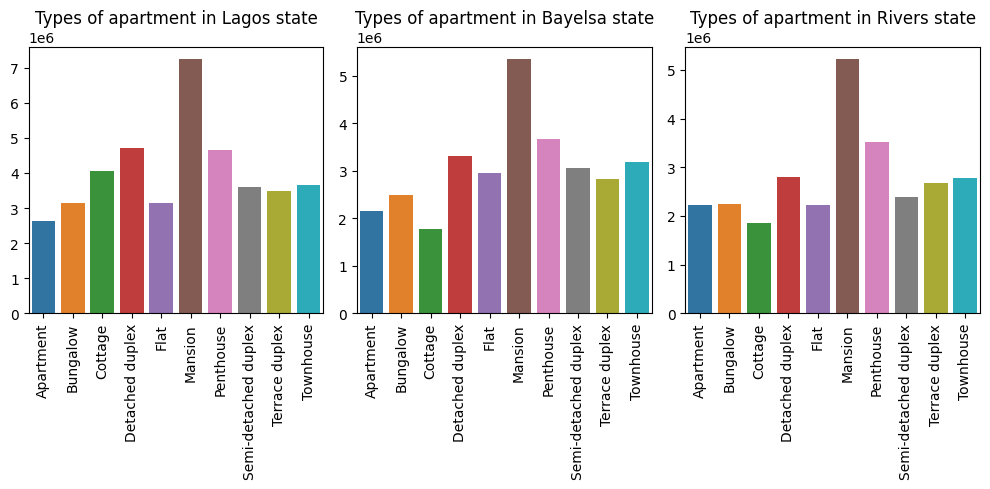

In [166]:
from pandas._libs.algos import unique_deltas
fig, axes = plt.subplots(1, 3, figsize = (10,5))

for i, grp in enumerate(["Lagos", "Bayelsa", "Rivers"]):
        avg_price_per_type = [] # create a list to store average price of the different types
        curr_grp_df = state_grouping.get_group(grp) # get the subset of df corresponding to the state
        uniq_types = np.unique(cat_df['title']) # get the possible different type of houses
        for t in uniq_types: #Loop through the different type of houses
          d = curr_grp_df[curr_grp_df['title']==t]['price'] #get all the price for that type of house
          avg_price_per_type.append(np.average(d)) # calculate the average and append to list
        sns.barplot(x = uniq_types, y = avg_price_per_type, ax = axes[i]) # Then plot out the average
        axes[i].tick_params(axis='x', labelrotation = 90)
        axes[i].set_title(f"Types of apartment in {grp} state")
fig.tight_layout()
plt.savefig('states.jpg')
plt.show()

# MODEL

## HElper functions

In [55]:
# Initialize different models
lr = LinearRegression()
dt = DecisionTreeRegressor()
gb = GradientBoostingRegressor()
rf = RandomForestRegressor()
xgb = xgboost.XGBRegressor()
cbt = CatBoostRegressor()
lass= Lasso()
ridge = Ridge()

models = [lr, dt, gb, rf, xgb, cbt, lass, ridge]
names = ['Linear Regression','DecisionTree','GradientBoosting','RandomForest','XGB','CATBOOST','Lasso','Rige']

def evaluate_models(xTrain, yTrain, xVal, yVal, scaled = False):
    random_seed= 0
    scores = []
    for i in range(len(models)): # Loop through the different models
        model = models[i]
        model.fit(xTrain, yTrain) # Fit the model on the dataset
        y_predicted = model.predict(xVal) #Predict for the test data
        if scaled: # if the scaled flag is passed then log was used to scale so we need to convert back with exp
          y_predicted = pd.Series(np.expm1(y_predicted))
        # Get the metrics
        mse = mean_squared_error(yVal, y_predicted)
        mae = mean_absolute_error(yVal, y_predicted)
        r_squared = r2_score(yVal, y_predicted)
        scores.append({
            'model':names[i],
            'mean_squared_error':mse,
            'mean_absolute_error':mae,
            'R_Squared': r_squared,
            "RMSE":np.sqrt(mse)
        })
    return pd.DataFrame(scores, columns=['model','mean_squared_error','mean_absolute_error', 'R_Squared', "RMSE"]) # create a datafram of metrics and resturn

In [12]:
def get_cv(X, y):
  # List to store the diff scores
    scores = []
    for i in range(len(models)): # Loop through models
        model = models[i]
        cv = np.mean(np.absolute(cross_val_score(model, X, y, cv = 5, scoring = 'neg_mean_squared_error'))) # calculate sv svore of mse
        scores.append({'model' : names[i],
                      'CV-RMSE' : np.sqrt(cv)}) # get RMSE and append to list of scores
    return pd.DataFrame(scores, columns = ['model', 'CV-RMSE']) # create df from scores

In [13]:
def gen_test_preds(model_name, test_data, train_d, target):
  ind = names.index(model_name) # get the model correspondimg to model name passed in tehn fit on data and return predictions
  model = models[ind]
  preds = model.fit(train_d, target).predict(test_data)
  return preds

## Trainings and evaluations

In [167]:
X = dropped.drop(["ID", "price"], axis = 1)
y = dropped["price"]

In [168]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y)

In [ ]:
cv_res = get_cv(X, y)

In [171]:
cv_res

,model,CV-RMSE
0,Linear Regression,869372.652179
1,DecisionTree,612330.246640
2,GradientBoosting,430088.917163
3,RandomForest,476603.933690
4,XGB,371322.667796
5,CATBOOST,338883.464277
6,Lasso,869372.652277
7,Rige,869372.637774


In [ ]:
eval_res = evaluate_models(xtrain, ytrain, xtest, ytest)

In [173]:
eval_res

,model,mean_squared_error,mean_absolute_error,R_Squared,RMSE
0,Linear Regression,9.087186e+11,600345.311194,0.257714,953267.320000
1,DecisionTree,4.593207e+11,339921.429190,0.624804,677732.006719
2,GradientBoosting,2.702243e+11,251122.872374,0.779267,519831.057329
3,RandomForest,3.345102e+11,293919.769508,0.726756,578368.533839
4,XGB,1.832275e+11,175607.316694,0.850331,428050.826998
5,CATBOOST,1.677125e+11,145890.273401,0.863004,409527.146206
6,Lasso,9.087185e+11,600345.302584,0.257714,953267.279275
7,Rige,9.087166e+11,600344.033315,0.257715,953266.301234


In [ ]:
preds = gen_test_preds("CATBOOST", test_cpy_dropped, X, y)

In [174]:
X_mode = mode_filled.drop(["ID", "price"], axis = 1)
y_mode = mode_filled["price"]

In [175]:
xtrain2, xtest2, ytrain2, ytest2 = train_test_split(X_mode, y_mode)

In [ ]:
vv_res = get_cv(X_mode, y_mode)

In [178]:
vv_res

,model,CV-RMSE
0,Linear Regression,921472.730275
1,DecisionTree,767975.816288
2,GradientBoosting,595079.217595
3,RandomForest,640741.190397
4,XGB,560231.055269
5,CATBOOST,542780.996292
6,Lasso,921472.730287
7,Rige,921472.724601


### Removing outliers

In [179]:
Q1 = dropped['price'].quantile(0.25) #get lower quartile
Q3 = dropped['price'].quantile(0.75) # get upper quartile

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

# Define the lower and upper bounds to identify outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers with the condition
outlier_free_dropped = dropped[(dropped['price'] >= lower_bound) & (dropped['price']<= upper_bound)]

In [180]:
dropped.shape

(5689, 7)

In [181]:
outlier_free_dropped.shape

(5451, 7)

<Axes: >

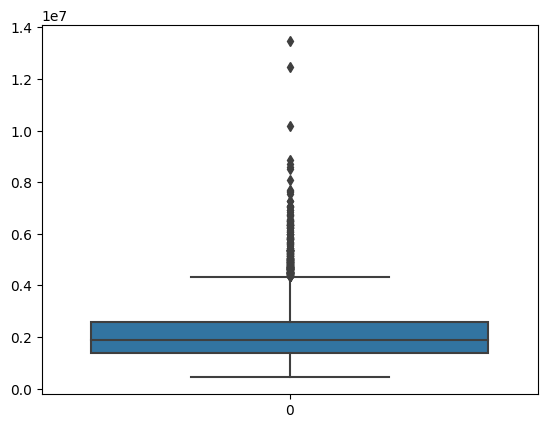

In [182]:
sns.boxplot(dropped["price"])

In [183]:
X_outlier_free = outlier_free_dropped.drop(["ID", "price"], axis = 1)
y_outfree = outlier_free_dropped["price"]

In [184]:
xtrain_outfree, xtest_outfree, ytrain_outfree, ytest_outfree = train_test_split(X_outlier_free, y_outfree)

In [ ]:
cv_res = get_cv(X_outlier_free, y_outfree)

In [186]:
cv_res

,model,CV-RMSE
0,Linear Regression,592774.136257
1,DecisionTree,443009.495914
2,GradientBoosting,312491.348524
3,RandomForest,339956.655563
4,XGB,254456.955444
5,CATBOOST,234476.658123
6,Lasso,592774.136436
7,Rige,592774.109566


In [ ]:
res = evaluate_models(xtrain_outfree, ytrain_outfree, xtest_outfree, ytest_outfree)

In [188]:
res

,model,mean_squared_error,mean_absolute_error,R_Squared,RMSE
0,Linear Regression,3.776131e+11,454038.827040,0.412004,614502.350411
1,DecisionTree,2.266892e+11,283232.829758,0.647013,476118.869996
2,GradientBoosting,1.041337e+11,215594.941786,0.837849,322697.502300
3,RandomForest,1.197926e+11,222957.949949,0.813466,346110.606279
4,XGB,6.616371e+10,131503.524020,0.896974,257223.070707
5,CATBOOST,5.299546e+10,109631.789731,0.917479,230207.423820
6,Lasso,3.776131e+11,454038.834912,0.412004,614502.320136
7,Rige,3.776129e+11,454040.346165,0.412004,614502.133239


In [ ]:
preds = gen_test_preds("CATBOOST", test_cpy_dropped, X_outlier_free, y_outfree)

## Scaling down the price column

In [189]:
scaled_y = np.log1p(y)

In [190]:
xtrain_sca, xtest_sca, ytrain_sca, ytest_sca = train_test_split(X, scaled_y)

In [ ]:
res = evaluate_models(xtrain_sca, ytrain_sca, xtest_sca, np.expm1(ytest_sca), scaled = True)

In [192]:
res

,model,mean_squared_error,mean_absolute_error,R_Squared,RMSE
0,Linear Regression,7.622026e+11,545887.066756,0.333066,8.730422e+05
1,DecisionTree,3.743402e+11,328387.136354,0.672449,6.118335e+05
2,GradientBoosting,1.714780e+11,229775.124493,0.849955,4.140990e+05
3,RandomForest,2.535248e+11,288063.747764,0.778164,5.035124e+05
4,XGB,1.240894e+11,145760.950814,0.891421,3.522633e+05
5,CATBOOST,9.699142e+10,118887.828901,0.915132,3.114345e+05
6,Lasso,1.192706e+12,756483.651853,-0.043627,1.092111e+06
7,Rige,7.622041e+11,545885.472231,0.333065,8.730430e+05


In [ ]:
preds = gen_test_preds("CATBOOST", test_cpy_dropped, X, scaled_y)

In [60]:
preds_f = np.expm1(preds)
preds_f

array([2360412.13383568, 1022604.12058422, 1213245.4805727 , ...,
       1942558.45109628, 1304231.48459413, 3467742.05985338])

In [61]:
sub = pd.DataFrame()
sub["ID"] = test_cpy_dropped["ID"]
sub["price"] = preds_f

In [62]:
sub.to_csv('submissions-6.csv', index= False)